<a href="https://colab.research.google.com/github/LuisErnestoColchado/EnvironmentalPollution/blob/master/30_10hrs_LSTM.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
#!/usr/bin/env python3
# -*- coding: utf-8 -*-
"""
Created on Thu Apr 25 11:27:47 2019

@author: luisernestocolchado
"""

# -*- coding: utf-8 -*-
"""
Spyder Editor

This is a temporary script file.
"""

# DL libraries
import tensorflow as tf
from tensorflow.contrib import rnn
from tensorflow.python.ops import variable_scope
from tensorflow.python.framework import dtypes

# Data Manipulation
import numpy as np 
import pandas as pd
import random
import math

# Files/OS
import os
import copy

# Visualization
import matplotlib.pyplot as plt
import seaborn as sns

# Benchmarking
import time

# Error Analysis
from sklearn.metrics import mean_squared_error
from sklearn.metrics import r2_score

from sklearn.preprocessing import MinMaxScaler
from pandas import DataFrame
from pandas import concat

from keras.models import Model, Sequential
from keras.layers import Dense, Input, concatenate, Dropout
from keras.layers import LSTM
from keras.layers.core import Reshape
from sklearn.metrics import mean_squared_error
from math import sqrt
from sklearn.model_selection import KFold
from sklearn.ensemble import RandomForestRegressor

Using TensorFlow backend.


In [2]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [3]:
import tensorflow as tf
device_name = tf.test.gpu_device_name()
if device_name != '/device:GPU:0':
  raise SystemError('GPU device not found')
print('Found GPU at: {}'.format(device_name))

Found GPU at: /device:GPU:0


   No  year  month  day  hour  pm2.5  DEWP  TEMP    PRES cbwd    Iws  Is  Ir
0   1  2010      1    1     0    NaN   -21 -11.0  1021.0   NW   1.79   0   0
1   2  2010      1    1     1    NaN   -21 -12.0  1020.0   NW   4.92   0   0
2   3  2010      1    1     2    NaN   -21 -11.0  1019.0   NW   6.71   0   0
3   4  2010      1    1     3    NaN   -21 -14.0  1019.0   NW   9.84   0   0
4   5  2010      1    1     4    NaN   -20 -12.0  1018.0   NW  12.97   0   0


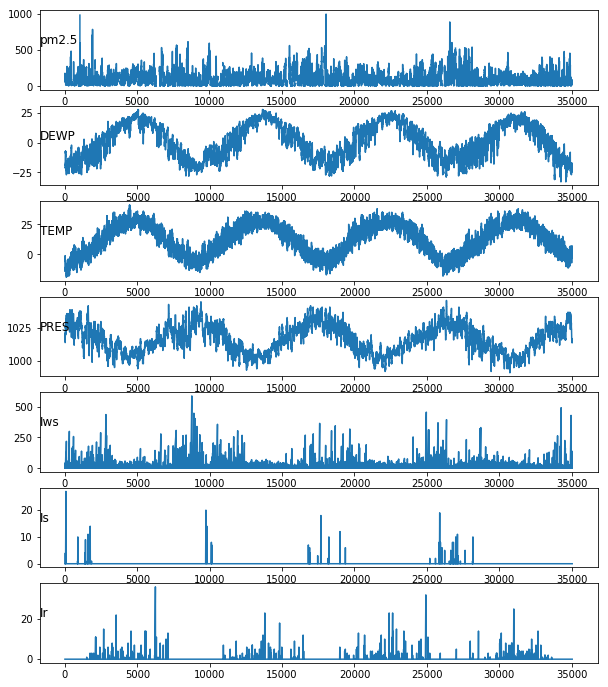

In [4]:
df = pd.read_csv('/content/drive/My Drive/masterTesis/code/data/data.csv')
print(df.head())
train = df.iloc[:365*24*4,]

cols_to_plot = ["pm2.5", "DEWP", "TEMP", "PRES", "Iws", "Is", "Ir"]
i = 1
# plot each column
plt.figure(figsize = (10,12))
for col in cols_to_plot:
    plt.subplot(len(cols_to_plot), 1, i)
    plt.plot(train[col])
    plt.title(col, y=0.5, loc='left')
    i += 1
plt.show()
df = df.drop(columns=['No'])

In [0]:
## ONE-HOT ENCODE WIND DIRECTION 
temp = pd.get_dummies(df['cbwd'], prefix='cbwd')
df = pd.concat([df, temp], axis = 1)
del df['cbwd'], temp

In [0]:
# convert series to supervised learning
def series_to_supervised(data, n_in=1, n_out=1, dropnan=True):
    n_vars = 1 if type(data) is list else data.shape[1]
    df = DataFrame(data)
    cols, names = list(), list()
    # input sequence (t-n, ... t-1)
    for i in range(n_in, 0, -1):
        cols.append(df.shift(i))
        names += [('var%d(t-%d)' % (j+1, i)) for j in range(n_vars)]
    # forecast sequence (t, t+1, ... t+n)
    for i in range(0, n_out):
        cols.append(df.shift(-i))
        if i == 0:
            names += [('var%d(t)' % (j+1)) for j in range(n_vars)]
        else:
            names += [('var%d(t+%d)' % (j+1, i)) for j in range(n_vars)]
    # put it all together
    agg = concat(cols, axis=1)
    agg.columns = names
    # drop rows with NaN values
    if dropnan:
        agg.dropna(inplace=True)
    return agg


In [7]:
reframed = series_to_supervised(df, 30, 10)
# drop columns we don't want to predict
print(reframed.iloc[0,:])

var1(t-30)     2010.00
var2(t-30)        1.00
var3(t-30)        2.00
var4(t-30)        0.00
var5(t-30)      129.00
var6(t-30)      -16.00
var7(t-30)       -4.00
var8(t-30)     1020.00
var9(t-30)        1.79
var10(t-30)       0.00
var11(t-30)       0.00
var12(t-30)       0.00
var13(t-30)       0.00
var14(t-30)       1.00
var15(t-30)       0.00
var1(t-29)     2010.00
var2(t-29)        1.00
var3(t-29)        2.00
var4(t-29)        1.00
var5(t-29)      148.00
var6(t-29)      -15.00
var7(t-29)       -4.00
var8(t-29)     1020.00
var9(t-29)        2.68
var10(t-29)       0.00
var11(t-29)       0.00
var12(t-29)       0.00
var13(t-29)       0.00
var14(t-29)       1.00
var15(t-29)       0.00
                ...   
var1(t+8)      2010.00
var2(t+8)         1.00
var3(t+8)         3.00
var4(t+8)        14.00
var5(t+8)        96.00
var6(t+8)       -11.00
var7(t+8)        -9.00
var8(t+8)      1020.00
var9(t+8)       116.66
var10(t+8)       20.00
var11(t+8)        0.00
var12(t+8)        0.00
var13(t+8) 

In [0]:
scalerxTrain = MinMaxScaler(feature_range=(0, 1))
scaleryTrain = MinMaxScaler(feature_range=(0, 1))
scalerxTest = MinMaxScaler(feature_range=(0, 1))
scaleryTest = MinMaxScaler(feature_range=(0, 1))

In [9]:
reframed.shape

(35583, 600)

In [0]:
fulldata = reframed.iloc[0:35000,:].values

In [11]:
print(fulldata)

[[2.010e+03 1.000e+00 2.000e+00 ... 0.000e+00 1.000e+00 0.000e+00]
 [2.010e+03 1.000e+00 2.000e+00 ... 0.000e+00 1.000e+00 0.000e+00]
 [2.010e+03 1.000e+00 2.000e+00 ... 0.000e+00 1.000e+00 0.000e+00]
 ...
 [2.014e+03 1.100e+01 2.900e+01 ... 1.000e+00 0.000e+00 0.000e+00]
 [2.014e+03 1.100e+01 2.900e+01 ... 1.000e+00 0.000e+00 0.000e+00]
 [2.014e+03 1.100e+01 2.900e+01 ... 1.000e+00 0.000e+00 0.000e+00]]


In [0]:
def lstm(xtrain,ytrain):
  inputs = Input((1,xtrain.shape[1]))
  
  #~inputs = Embedding(output_dim=xtrain.shape[0], input_dim=10000, input_length=100)(main_input)
  
  lstm1 = LSTM(200,input_shape=(1,xtrain.shape[1]),return_sequences=True)
  lstmPm25 = lstm1(inputs)
  lstm2 = LSTM(200,return_sequences=True)(lstmPm25)
  lstmPm25 = Dense(150,activation='sigmoid')(lstm2)
  lstmModel1 = Model(inputs, lstmPm25)
  return lstmModel1

def randomForest(xtrain,ytrain,xtest):
  regressor = RandomForestRegressor(n_estimators=100, random_state=0)  
  regressor.fit(xtrain, ytrain)  
  y_pred = regressor.predict(xtest)  
  return y_pred

In [17]:
kFolds = KFold(n_splits=5)
countCross = 1 
for train, test in kFolds.split(fulldata):
    xTrain = fulldata[train,0:fulldata.shape[1] - 150]
    xTest= fulldata[test,0:fulldata.shape[1] - 150] 
    yTrain = fulldata[train,fulldata.shape[1] - 150:]
    yTest = fulldata[test,fulldata.shape[1] - 150:]
    xTrain = scalerxTrain.fit_transform(xTrain)
    xTest = scalerxTest.fit_transform(xTest)
    yTrain = scaleryTrain.fit_transform(yTrain)
    yTest = scaleryTest.fit_transform(yTest)
    print("------------- CROSS VALIDATION ",countCross,"---------")
    print("**********LTSM NN***********")
    model = lstm(xTrain,yTrain)
    print(model.summary())
    model.compile(loss='mae', optimizer='adam') 
    xTrain = np.reshape(xTrain,(xTrain.shape[0],1,xTrain.shape[1]))
    yTrain = np.reshape(yTrain,(yTrain.shape[0],1,yTrain.shape[1]))
    
    model.fit(xTrain, yTrain, epochs=100, batch_size=1000)
    
    xTest = np.reshape(xTest,(xTest.shape[0],1,xTest.shape[1]))
    
    yhat = model.predict(xTest)
    
    yhat = np.reshape(yhat,(yTest.shape[0],yTest.shape[1]))
    print(yhat.shape)
    predictTest = scaleryTest.inverse_transform(yhat)
    yTestI = scaleryTest.inverse_transform(yTest)
    rmseTest = sqrt(mean_squared_error(yTestI, predictTest))
    print("RMSE ", rmseTest)
    countCross+=1

------------- CROSS VALIDATION  1 ---------
**********LTSM NN***********
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_5 (InputLayer)         (None, 1, 450)            0         
_________________________________________________________________
lstm_9 (LSTM)                (None, 1, 200)            520800    
_________________________________________________________________
lstm_10 (LSTM)               (None, 1, 200)            320800    
_________________________________________________________________
dense_5 (Dense)              (None, 1, 150)            30150     
Total params: 871,750
Trainable params: 871,750
Non-trainable params: 0
_________________________________________________________________
None
Epoch 1/100
28000/28000 [==============================] - 2s 76us/step - loss: 0.2757
Epoch 2/100
28000/28000 [==============================] - 0s 13us/step - loss: 0.1811
Epoch 3/100
2800